<p style="font-family: Verdana; letter-spacing: 2px; color:#000000; font-size:300%; padding: 0px; text-align:center;">
    <b>🤗 FinBERT for Sentiment Analysis 🤗</b>
    
    
In this short notebook I will show how you can use FinBERT easily for sentiment analysis. 
FinBERT is a pre-trained NLP model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification. [Financial PhraseBank](https://www.researchgate.net/publication/251231107_Good_Debt_or_Bad_Debt_Detecting_Semantic_Orientations_in_Economic_Texts) by Malo et al. (2014) is used for fine-tuning. For more details, please see the paper [FinBERT: Financial Sentiment Analysis with Pre-trained Language Models](https://arxiv.org/abs/1908.10063) and our related blog post on Medium.

The model will give softmax outputs for three labels: positive, negative or neutral.

# 1 SETUP

In [1]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

I now read the input file. I will add the column headers, since they are not present in the csv file. 

In [2]:
data = pd.read_csv('/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv', 
                   encoding='unicode_escape',
                   names=['Sentiment', 'Text'])
data.head()

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
data.shape

(4846, 2)

In total we have 4846 observations for those we can predict the sentiment. 

# 2 PREPARATION
The first thing we do, is to separate the columns. The `Text` column will be our `X` which we will feed into FinBERT and `Sentiment` is our target in which we are interested, I will safe it into `y`. 
There is no need to specify a train or testset, we will use the pretrained model directly to predict the sentiment. 

In [4]:
X = data['Text'].to_list()
y = data['Sentiment'].to_list()

In the next step I will directly download [FinBERT](https://huggingface.co/ProsusAI/finbert) directly from Huggingface. 

In [5]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# 3 PREDICT
Finally we are able to loop over the X list and predict for every entry the label. I will safe the predicted label as well as the probability for that class.

In [6]:
preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model(**input_sequence).logits
        scores = {
        k: v
        for k, v in zip(
            model.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

# 4 EVALUATION
Let´s check the performance of our model quick. 

In [7]:
print(f'Accuracy-Score: {accuracy_score(y, preds)}')

Accuracy-Score: 0.8893933140734627


In [8]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

    negative       0.80      0.97      0.88       604
     neutral       0.96      0.86      0.91      2879
    positive       0.81      0.92      0.86      1363

    accuracy                           0.89      4846
   macro avg       0.86      0.92      0.88      4846
weighted avg       0.90      0.89      0.89      4846



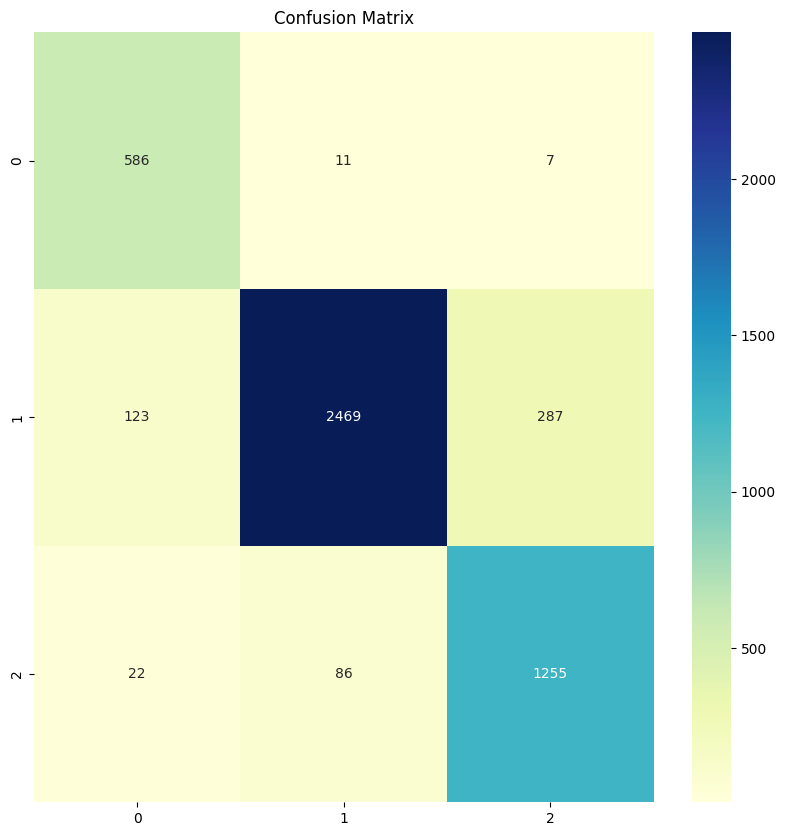

In [9]:
cm = confusion_matrix(y, preds)
cm_matrix = pd.DataFrame(data=cm)
plt.figure(figsize=(10,10))
sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Confusion Matrix')
plt.show();

The output is really good. Around 89% accuracy without any fine-tuning. 